In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 18 09:55:59 2022

@author: pwiechen
"""
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import root
import matplotlib.patches as pat
import matplotlib.dates as mdates
import pytz
import netCDF4 as nc4
import scipy.signal
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.fftpack import fft    #importing Fourier transform package
from scipy.stats import chi2     #importing confidence interval package

from scipy.optimize import root


start_time = datetime(2022,9,26,16,0,0).timestamp()
end_time = datetime(2022,9,26,16,15,0).timestamp()

In [2]:
# Air pressure at Hoek van Holland

types_dict_ap = {'STN': str,'YYYYMMDD': str,'HH': float,'P': float}
air_pressure_raw = pd.read_csv('C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/uurgeg_330_2021-2030.txt', skiprows=32, delimiter=',', skipinitialspace=True, usecols=[0,1,2,14], dtype=types_dict_ap, names=['STN','YYYYMMDD','HH','P'])
air_pressure_raw['time'] = np.zeros(len(air_pressure_raw['YYYYMMDD'].values))

for i in range(len(air_pressure_raw['time'])):
    air_pressure_raw['time'][i] = pd.to_datetime(air_pressure_raw['YYYYMMDD'].values[i], format="%Y%m%d") + timedelta(hours=air_pressure_raw['HH'].values[i])
   
air_pressure_raw.drop(columns=['YYYYMMDD', 'HH'], inplace=True)
air_pressure_HvH = air_pressure_raw[air_pressure_raw.STN.str.contains('330')]
air_pressure_HvH.rename(columns={"pressure":"pressure_HvH"}, inplace=True)

air_pressure_HvH['time'] = air_pressure_HvH['time'] + timedelta(seconds=3600)

air_pressure_HvH = air_pressure_HvH.drop(air_pressure_HvH[air_pressure_HvH.time<"2022-09-23 09:00:00"].index)

display(air_pressure_HvH)
#del i, types_dict_ap,  air_pressure_HvH, air_pressure_raw

#air_pressure_HvH.to_csv(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/dataset_air_pressure_HvHe_KNMI.csv')

<ipython-input-2-5cb6ad8ec11e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_pressure_raw['time'][i] = pd.to_datetime(air_pressure_raw['YYYYMMDD'].values[i], format="%Y%m%d") + timedelta(hours=air_pressure_raw['HH'].values[i])


,STN,P,time
15127,330,10156.0,2022-09-23 09:00:00
15128,330,10157.0,2022-09-23 10:00:00
15129,330,10156.0,2022-09-23 11:00:00
15130,330,10152.0,2022-09-23 12:00:00
15131,330,10150.0,2022-09-23 13:00:00
...,...,...,...
15235,330,9968.0,2022-09-27 21:00:00
15236,330,9963.0,2022-09-27 22:00:00
15237,330,9963.0,2022-09-27 23:00:00
15238,330,9961.0,2022-09-28 00:00:00


In [3]:
def rbr_data_reader(file):
    
    '''
    Conversion of RBR file to workable dataframe. Note that the time is assumed to be CET,
    and therefore the conversion to time_unix subtracts 3600 s because the pd.to_numeric assumes GMT.
    
    BE CAREFUL! THIS FUNCTION ASSUMES WINTER TIME (UTC + 2HR)
    '''
    
    rbr_raw = pd.read_csv(file, parse_dates=['Time'])#, date_parser=dateparse_rbr)

    rbr = pd.DataFrame({
        'time':rbr_raw.Time,
        'time_unix': pd.to_numeric(rbr_raw.Time)/10**9-7200,  # If summertime subtract 7200 s
        'dt_s': np.arange(0,len(rbr_raw.Time)*0.125, 0.125),
        'pressure':rbr_raw.Pressure * 0.1 * 100000}) #dbar
    
    return rbr

def smooth(x,window_len,window):

    if x.ndim != 1:
        raise ValueError # "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError #"Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError #"Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(window_len/2-1):-int(window_len/2)]


def disper3(k,omega,h):
    g = 9.81
    return omega**2-g*k*np.tanh(k*h)

def p2sse(t,pressure,z_sensor, h_bed, cutoff):
    
    """
    Input:
        
        t: array with timestamps [s]
        pressure: array of the measured pressure [dbar]
        z_sensor: location of the sensor in coordinate system
        h_bed = distance from the bed (positive upward) [m]
        cutoff: cutoff frequency to avoid signal from blowing up [Hz]
        
    Output:
        eta: surface elevation timeseries
        eta_mean: mean water level
    """
    # Detrend the data using a smoothing function with a window of 15 minutes
    g = 9.81
    h = np.mean(pressure) + h_bed
    
    window_length = int(2*np.round(15*60/(t[1]-t[0])/2, decimals = 0))
    
    mean_pres = smooth(pressure, window_length, 'hanning') + np.mean(pressure - smooth(pressure, window_length, 'hanning'))
    mean = mean_pres*10000/(9.81*1025)
        
    pres_detrend = pressure - mean_pres
    
    plt.figure()
    plt.plot(t, pressure, label='Pressure signal')
    plt.plot(t, mean, label='Trend that is deleted within analysis')
    plt.grid()
    plt.legend()
    plt.show()
        
    # FFT stuff:
        
    delta_t = t[1]-t[0]
    nfft = len(t)
    D = (nfft)*delta_t
    fs = 1/(delta_t)
    df = 1/D
    f = np.arange(0,fs,df)
    
    Fpres = np.fft.fft(pres_detrend,nfft)/nfft
    
    # Avoid problem with np.arange (normally last value is not included)
    if len(f) != len(Fpres):
        f = f[:-1]
        
    k_linear = np.zeros(len(f))
    
    # initial estimate of k using Eckart 1952
    alpha = 4*np.pi**2*h/(g*(1/f[1])**2)
    k_linear_previous = alpha/h * np.sqrt(np.cosh(alpha)/np.sinh(alpha))
        
    for i in range(len(f)):
        #print(100*np.round((i+1)/len(f),decimals = 2), ' % progress')
        
        if i > 0:
            k_linear_sol = root(disper3,k_linear_previous, args=(2*np.pi*f[i],h), method = 'lm')
            k_linear[i] = k_linear_sol.x
            k_linear_previous = k_linear_sol.x
        if k_linear_previous < 0:
            k_linear_previous = 0.0001
            print('Caution, negative k-value found in iteration for frequency: ', f[i], ' Hz')
    
    cutoff_index_begin = int(np.argwhere(f>=cutoff)[0])  
    cutoff_index_end = int(np.argwhere(f>=f[-1] - cutoff)[0]) 
    k_linear[cutoff_index_begin:] = 1 
    
    if h_bed >= 0:
        factor =  np.cosh(k_linear*h)/(np.cosh(k_linear*h_bed))
    else:
        factor = np.cosh(k_linear*h)/(np.exp(k_linear*h_bed))
        
    k_linear[0] = k_linear[1] # Replace to avoid a divide by zero error
    factor[0] = 1
    
    # Use method of Bishop and Donelan 1987
    
    L = 2*np.pi/k_linear
    dS = h - h_bed
    maxFactor = 0.2
    
    factor[np.argwhere(dS/L > maxFactor)] = np.max(factor[np.argwhere(dS/L <= maxFactor)])
   
    cutoff_index_begin = int(np.argwhere(f>=cutoff)[0])  
    cutoff_index_end = int(np.argwhere(f>=f[-1] - cutoff)[0]) 
    
    factor[cutoff_index_begin:cutoff_index_end] = 0 
    
    factor[cutoff_index_end:] = np.flip(factor[1:cutoff_index_begin+1])
    
    Fnew = factor*Fpres
    
    eta = np.real(np.fft.ifft(Fnew,nfft)*nfft)
    eta_mean = mean + z_sensor
    
    return eta, eta_mean

In [4]:
## Load rbr data
rbr_01 = rbr_data_reader(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/RBR1/RBR 1 data 23-9 tm 28-9/RBR 1 data 23-9 tm 28-9_data.txt')
rbr_02 = rbr_data_reader(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/RBR2/RBR 2 data 23-9 tm 28-9/RBR 2 data 23-9 tm 28-9_data.txt')
rbr_03 = rbr_data_reader(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/RBR3/RBR 3 data 23-9 tm 28-9/RBR 3 data 23-9 tm 28-9_data.txt')
rbr_04 = rbr_data_reader(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/RBR4/RBR 4 data 23-9 tm 28-9/RBR 4 data 23-9 tm 28-9_data.txt')

In [5]:
## Air pressure

start_exp = "2022-09-26 15:00:00"
end_exp = "2022-09-26 17:0:00"

air_pres_int = (air_pressure_HvH.loc[air_pressure_HvH['time'] == start_exp, 'P'].iloc[0] + air_pressure_HvH.loc[air_pressure_HvH['time'] == end_exp, 'P'].iloc[0]) / 2
#print(air_pres2)

air_pres = air_pres_int * 10 #bar to Pa

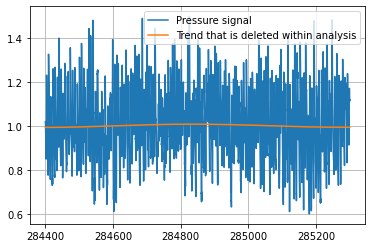

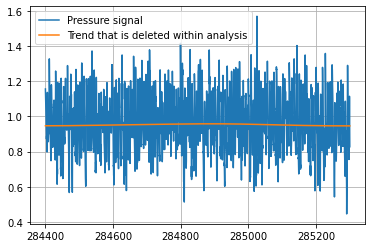

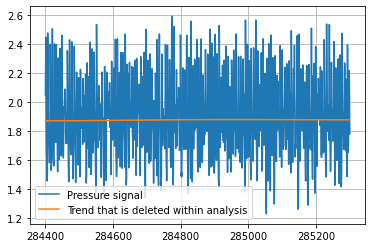

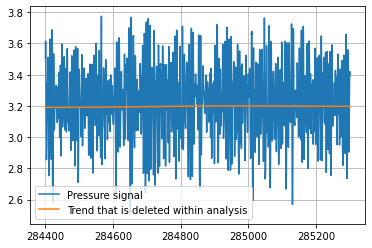

In [6]:
##Convert from pressure to surface elevation
start_time = datetime(2022,9,26,16,0,0).timestamp()
end_time = datetime(2022,9,26,16,15,0).timestamp()

index_start = np.where(rbr_02['time_unix'] >= start_time)[0][0]
index_end = np.where(rbr_02['time_unix'] > end_time)[0][0]

z_sensor_rbr01 = 0.644- 0.21 #NAP
h_bed_rbr01 = 0.05

z_sensor_rbr02 = 0.626 - 0.21 #NAP
h_bed_rbr02 = 0.05

z_sensor_rbr03 = 0.289 - 0.21 #NAP
h_bed_rbr03 = 0.34

z_sensor_rbr04 = -1.238 - 0.21 #NAP
h_bed_rbr04 = 0.19

rbr_01_eta, rbr_01_eta_mean = p2sse(rbr_01['dt_s'].values[index_start:index_end], (rbr_01['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr01, h_bed_rbr01, 1)
rbr_02_eta, rbr_02_eta_mean = p2sse(rbr_02['dt_s'].values[index_start:index_end], (rbr_02['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr02, h_bed_rbr02, 1)
rbr_03_eta, rbr_03_eta_mean = p2sse(rbr_03['dt_s'].values[index_start:index_end], (rbr_03['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr03, h_bed_rbr03, 1)
rbr_04_eta, rbr_04_eta_mean = p2sse(rbr_04['dt_s'].values[index_start:index_end], (rbr_04['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr04, h_bed_rbr04, 1)

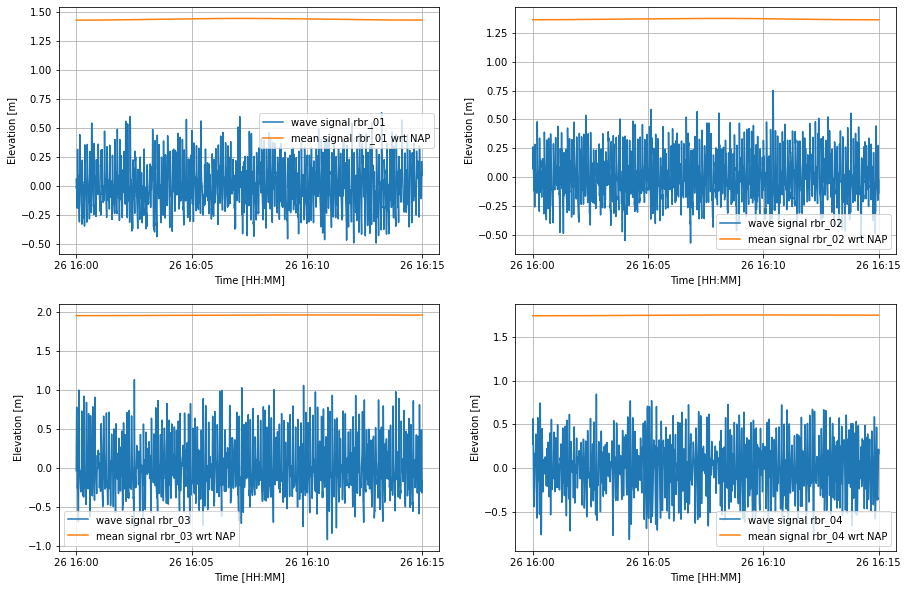

In [7]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.plot(rbr_01['time'][index_start:index_end], rbr_01_eta, label='wave signal rbr_01')
plt.plot(rbr_01['time'][index_start:index_end], rbr_01_eta_mean, label='mean signal rbr_01 wrt NAP')

plt.xlabel('Time [HH:MM]')
plt.ylabel('Elevation [m]')

plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rbr_02['time'][index_start:index_end], rbr_02_eta, label='wave signal rbr_02')
plt.plot(rbr_02['time'][index_start:index_end], rbr_02_eta_mean, label='mean signal rbr_02 wrt NAP')

plt.xlabel('Time [HH:MM]')
plt.ylabel('Elevation [m]')

plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(rbr_03['time'][index_start:index_end], rbr_03_eta, label='wave signal rbr_03')
plt.plot(rbr_03['time'][index_start:index_end], rbr_03_eta_mean, label='mean signal rbr_03 wrt NAP')

plt.xlabel('Time [HH:MM]')
plt.ylabel('Elevation [m]')

plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(rbr_04['time'][index_start:index_end], rbr_04_eta, label='wave signal rbr_04')
plt.plot(rbr_04['time'][index_start:index_end], rbr_04_eta_mean, label='mean signal rbr_04 wrt NAP')

plt.xlabel('Time [HH:MM]')
plt.ylabel('Elevation [m]')

plt.grid()
plt.legend()


In [8]:
def wave_spectrum(data,nfft,Fs):
    ''' Compute variance spectral density spectrum of the time-series and its 
    90% confidence intervals. 
    The time-series is first divided into blocks of length nfft before being 
    Fourier-transformed.

    INPUT
      data    timeseries 
      nfft    block length
       Fs     sampling frequency (Hz)
    
    OUTPUT
      E       variance spectral density. If data is in meters, E is in m^2/Hz
      f       frequency axis (Hz)
      confLow and confUpper     Lower and upper 90% confidence interval; 
                                (Multiplication factors for E)  '''
    
    # 1. PRELIMINARY CALCULATIONS
    # ---------------------------
    n = len(data)                # length of the time-series
    nfft = int(nfft - (nfft%2))  # the length of the window should be an even number

    data = scipy.signal.detrend(data)      # detrend the time-series
    nBlocks = int(n/nfft)        # number of blocks (use of int to make it an integer)

    data_new = data[0:nBlocks*nfft] # (we work only with the blocks which are complete)

    # we organize the initial time-series into blocks of length nfft 
    dataBlock = np.reshape(data_new,(nBlocks,nfft))  # each column of dataBlock is one block
    
    # 2. CALCULATION VARIANCE DENSITY SPECTRUM
    # ----------------------------------------

    # definition frequency axis
    df = Fs/nfft      # frequency resolution of the spectrum df = 1/[Duration of one block]
    f = np.arange(0,Fs/2+df,df)   # frequency axis (Fs/2 = Fnyquist = max frequency)
    fId = np.arange(0,len(f))

    # Calculate the variance for each block and for each frequency
    fft_data = fft(dataBlock,n = nfft,axis = 1)      # Fourier transform of the data 
    fft_data = fft_data[:,fId]            # Only one side needed
    A = 2.0/nfft*np.real(fft_data)          # A(i,b) and B(i,b) contain the Fourier coefficients Ai and Bi for block b
    B = 2.0/nfft*np.imag(fft_data)          #  -- see LH's book, page 325 for definition of Ai and Bi
                                          # /!\ assumes that mean(eta)=0 

    E = (A**2 + B**2)/2.                  # E(i,b) = ai^2/2 = variance at frequency fi for block b. 

    # We finally average the variance over the blocks, and divide by df to get the variance DENSITY spectrum
    E = np.mean(E, axis = 0)/df
    
    # 3. CONFIDENCE INTERVALS
    # -----------------------
    edf = round(nBlocks*2)   # Degrees of freedom 
    alpha = 0.1              # calculation of the 90% confidence interval

    confLow = edf/chi2.ppf(1-alpha/2,edf)    # see explanations on confidence intervals given in lecture 3 
    confUpper  = edf/chi2.ppf(alpha/2,edf)
    
    return E,f,confLow,confUpper

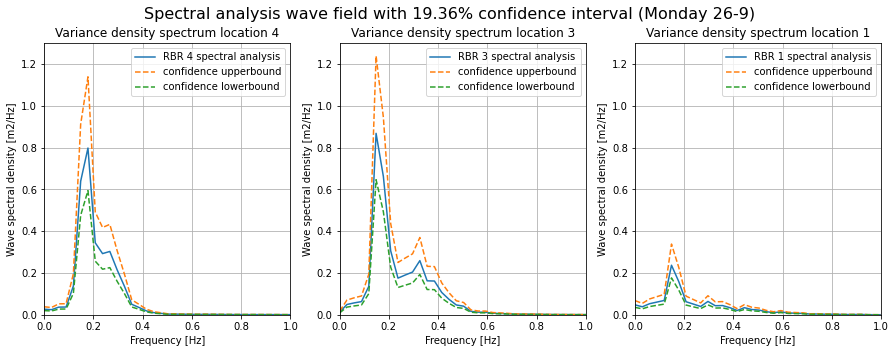

In [37]:
n = 270                                    #number of subblocks
error = 100/np.sqrt(len(rbr_01_eta)/n)
#print(error)
#print(n)

fig = plt.figure(figsize=(15, 5))
fig.suptitle(f"Spectral analysis wave field with {error:.2f}% confidence interval (Monday 26-9)", fontsize=16)

plt.subplot(1,3,3)
E1, f1, Conflow, Confupper = wave_spectrum(rbr_01_eta, n, 8)
plt.plot(f1, E1, label = 'RBR 1 spectral analysis')
plt.plot(f1, Confupper * E1, label = 'confidence upperbound', ls='--')
plt.plot(f1, Conflow * E1, label = 'confidence lowerbound', ls='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.3])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Wave spectral density [m2/Hz]')
plt.grid()
plt.title("Variance density spectrum location 1")
plt.legend()

# plt.subplot(2,2,2)
# E2, f2, Conflow2, Confupper2 = wave_spectrum(rbr_02_eta, n, 8)
# plt.plot(f2, E2, label = 'RBR 2 spectral analysis')
# plt.plot(f2, Confupper2 * E2, label = 'confidence upperbound')
# plt.plot(f2, Conflow2 * E2, label = 'confidence lowerbound')
# plt.xlim([0, 1.0])
# plt.ylim([0, 1.2])
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Wave spectral density [m2/Hz]')
# plt.grid()
# plt.title("Variance density spectrum location 2")
# plt.legend()

plt.subplot(1,3,2)
E3, f3, Conflow3, Confupper3 = wave_spectrum(rbr_03_eta, n, 8)
plt.plot(f3, E3, label = 'RBR 3 spectral analysis')
plt.plot(f3, Confupper3 * E3, label = 'confidence upperbound', ls='--')
plt.plot(f3, Conflow3 * E3, label = 'confidence lowerbound', ls='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.3])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Wave spectral density [m2/Hz]')
plt.grid()
plt.title("Variance density spectrum location 3")
plt.legend()

plt.subplot(1,3,1)
E4, f4, Conflow4, Confupper4 = wave_spectrum(rbr_04_eta, n, 8)
plt.plot(f4, E4, label = 'RBR 4 spectral analysis')
plt.plot(f4, Confupper4 * E4, label = 'confidence upperbound', ls='--')
plt.plot(f4, Conflow4 * E4, label = 'confidence lowerbound', ls='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.3])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Wave spectral density [m2/Hz]')
plt.grid()
plt.title("Variance density spectrum location 4")
plt.legend();

# plt.savefig("Spectral analysis wave field Monday 26-9.jpg")


In [30]:
delta_omega = f1[1]-f1[0]

# RBR 1
start = 0.0
stop = 1

integrated_value1 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value1 += E1[index]*delta_omega
Hs1 = 4*np.sqrt(integrated_value1)
print('Hs RBR1 =', round(Hs1,2),'m') 

# RBR 3
# start = 0
# stop = 1

integrated_value3 = 0
for index, frequency in enumerate(f3):
    if (frequency >= start) and (frequency <= stop):
        integrated_value3 += E3[index]*delta_omega
Hs3 = 4*np.sqrt(integrated_value3)
print('Hs RBR3 =', round(Hs3,2),'m') 


#  RBR 4
# start = 0
# stop = 1

integrated_value4 = 0
for index, frequency in enumerate(f4):
    if (frequency >= start) and (frequency <= stop):
        integrated_value4 += E4[index]*delta_omega
Hs4 = 4*np.sqrt(integrated_value4)
print('Hs RBR4 =', round(Hs4,2),'m') 

Hs RBR1 = 0.75 m
Hs RBR3 = 1.32 m
Hs RBR4 = 1.22 m


In [31]:
# RBR 1
# start = 0
# stop = 1

integrated_value1 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value1 += E1[index]*delta_omega
Hs1 = 4*np.sqrt(integrated_value1)
print('Hs RBR1 =', round(Hs1,2),'m') 

# upperbound
integrated_value11 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value11 += (Confupper * E1[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value11)
print('Hs RBR1 upperbound =', round(Hs_upper,2),'m') 

# Lowerbound
integrated_value12 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value12 += (Conflow * E1[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value12)
print('Hs RBR1 Lowerbound =', round(Hs_upper,2),'m') 

Hs RBR1 = 0.75 m
Hs RBR1 upperbound = 0.9 m
Hs RBR1 Lowerbound = 0.65 m


In [32]:
# RBR 3
# start = 0
# stop = 1

integrated_value3 = 0
for index, frequency in enumerate(f3):
    if (frequency >= start) and (frequency <= stop):
        integrated_value3 += E3[index]*delta_omega
Hs3 = 4*np.sqrt(integrated_value3)
print('Hs RBR3 =', round(Hs3,2),'m') 

# upperbound
integrated_value31 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value31 += (Confupper3 * E3[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value31)
print('Hs RBR3 upperbound =', round(Hs_upper,2),'m') 

# Lowerbound
integrated_value32 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value32 += (Conflow3 * E3[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value32)
print('Hs RBR3 Lowerbound =', round(Hs_upper,2),'m') 


Hs RBR3 = 1.32 m
Hs RBR3 upperbound = 1.57 m
Hs RBR3 Lowerbound = 1.14 m


In [33]:
#  RBR 4
# start = 0
# stop = 1

integrated_value4 = 0
for index, frequency in enumerate(f4):
    if (frequency >= start) and (frequency <= stop):
        integrated_value4 += E4[index]*delta_omega
Hs4 = 4*np.sqrt(integrated_value4)
print('Hs RBR4 =', round(Hs4,2),'m')

# upperbound
integrated_value41 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value41 += (Confupper4 * E4[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value41)
print('Hs RBR4 upperbound =', round(Hs_upper,2),'m') 

# Lowerbound
integrated_value42 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value42 += (Conflow4 * E4[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value42)
print('Hs RBR4 Lowerbound =', round(Hs_upper,2),'m') 

Hs RBR4 = 1.22 m
Hs RBR4 upperbound = 1.46 m
Hs RBR4 Lowerbound = 1.05 m
